In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx

In [2]:
from featureExtraction import featureExtraction
from bundleAdjustment import bundleAdjustment
from gainCompensation import gainCompensation

In [3]:
def loadImages(img_dir):
    img_names = os.listdir(img_dir)
    img_list = []
    # Load images
    for img_name in img_names:
        img = cv.imread(img_dir + img_name)
        img_list.append(img)

    return img_list

    

In [4]:
img_dir = "./data/setSmall/"
img_list = loadImages(img_dir)


In [5]:
fe = featureExtraction(img_list.copy(),method="FLANN")

In [6]:
fe.run()

Extracting SIFT features...
Generating matches...
Processing matches...
Computing homographies...
Computing adjacency matrix...


#### Visualizing the network

In [7]:
def display_network(adjacency_matrix):
    G = nx.Graph(adjacency_matrix)
    nx.draw(G, with_labels=True, font_weight='bold')
    plt.show()

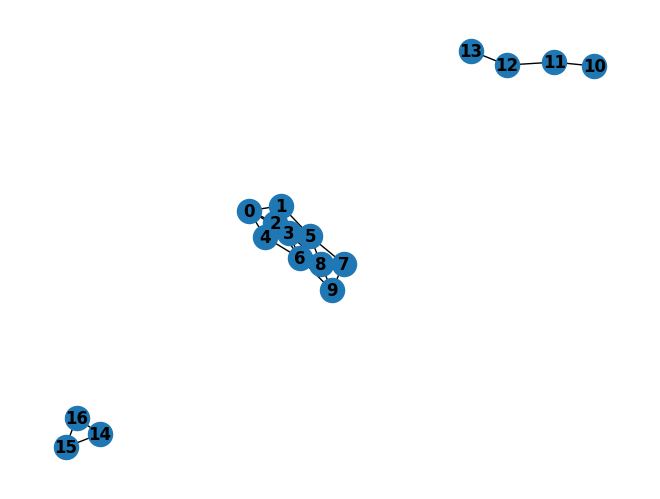

In [8]:
display_network(fe.adjacency_matrix)

In [9]:
numMatches=np.zeros((len(img_list),len(img_list)))
for i in range(len(img_list)):
    for j in range(len(img_list)):
        if fe.matches[i][j]==None:
            numMatches[i,j]=0
            continue
        numMatches[i,j]=-len(fe.matches[i][j]) # we take -ve wts as we want to retain the edges with more matches while applying MST
BA=bundleAdjustment(fe.matches.copy(),numMatches,fe.homographies.copy(),fe.image_list.copy(),fe.keypoints)
BA.run()

Building network and ordering...
Number of panoramas detected:  3
Performing bundle adjustment for each panorama...
Panorama  1
Panorama  2
Panorama  3
Completed bundle adjustment for all panoramas


In [19]:
def apply_filter(filter,image):
    # filter is a 1x3 array
    # image is a 2D array with 3 channels
    # returns a 2D array with 3 channels

    # convert image to float
    image = image.astype(np.float32)
    # apply filter
    image[:,:,0] = image[:,:,0]*filter[0]
    image[:,:,1] = image[:,:,1]*filter[1]
    image[:,:,2] = image[:,:,2]*filter[2]
    # convert back to uint8
    image = image.astype(np.uint8)
    return image

In [20]:
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop top
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop top
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop top
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

def stitch_images(image1,image2,H,gain1,gain2):
    image1 = apply_filter(gain1,image1)
    image2 = apply_filter(gain2,image2)


    width = 2*image1.shape[1] + image2.shape[1]
    height = 2*image1.shape[0] + image2.shape[0]

    # offset Homography by width and height of first image
    offset_matrix = np.eye(3)
    offset_matrix[0][2] = image1.shape[1]
    offset_matrix[1][2] = image1.shape[0]
    H_new = offset_matrix @ H
    result = cv.warpPerspective(image1, H_new, (width, height))
    result[image1.shape[0]:image2.shape[0]+image1.shape[0], image1.shape[1]:image2.shape[1]+image1.shape[1]] = image2

    return trim(result)



In [21]:
gain_list = []
gainCompensation(img_list.copy(),fe.matches.copy(),fe.homographies.copy(),gainList=gain_list)
print(gain_list)


(17, 17)
(17,)
(17, 17)
(17,)
(17, 17)
(17,)
[array([0.987977  , 0.98976419, 0.98837989]), array([0.99271479, 0.99677168, 0.99449303]), array([0.98574421, 0.99065159, 0.98641951]), array([0.98749702, 0.99257875, 0.98573853]), array([0.98612634, 0.99143487, 0.98727945]), array([0.98468025, 0.99393415, 0.99108108]), array([0.98395681, 0.99498838, 0.99013543]), array([0.95168092, 0.97513969, 0.9782209 ]), array([0.95976469, 0.97957237, 0.97965574]), array([0.96607943, 0.99274172, 0.99418403]), array([0.88376199, 0.89040466, 0.88290765]), array([0.88442628, 0.88360601, 0.86366489]), array([0.86770309, 0.87132825, 0.85094731]), array([0.83895462, 0.8639688 , 0.86310728]), array([0.96072694, 0.97699919, 0.97808002]), array([0.96617774, 0.97937896, 0.98012103]), array([0.96420986, 0.97802884, 0.97879645])]


In [27]:
gain_list[10]

array([0.88376199, 0.89040466, 0.88290765])

In [28]:
BA.paths

[[8, 7, 6, 9, 5, 3, 4, 2, 1, 0], [11, 10, 12, 13], [15, 16, 14]]

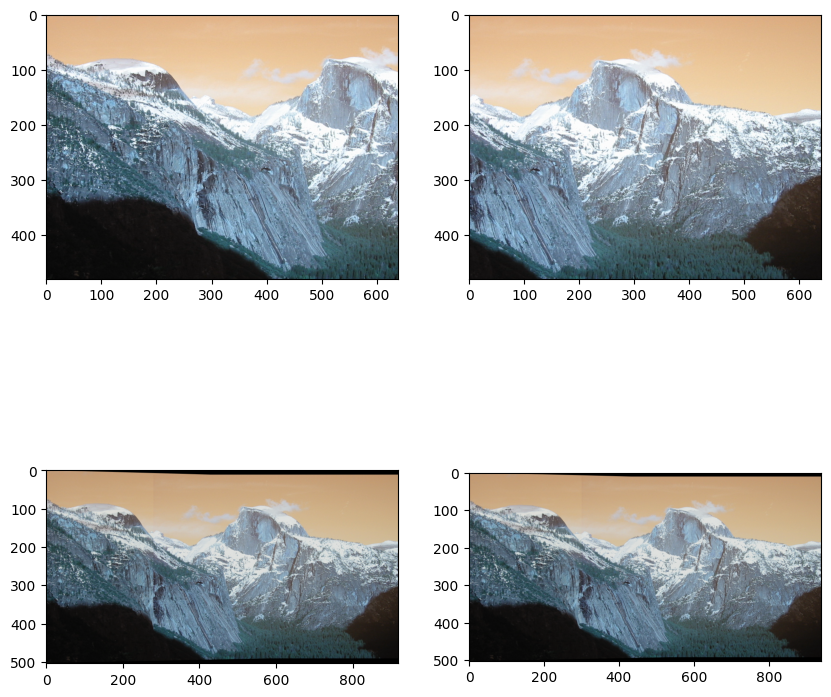

In [31]:
img1 = img_list[10]
img2 = img_list[11]
H = BA.bundleHomo[1][0]
H_1 = fe.homographies[10][11]
G_1 = gain_list[11]
G_2 = gain_list[10]
s = stitch_images(img1,img2,H,G_1,G_2)
s_1 = stitch_images(img1,img2,H_1,G_1,G_2)

ax, fig = plt.subplots(2,2,figsize=(10,10))
fig[0,0].imshow(img1)
fig[0,1].imshow(img2)
fig[1,0].imshow(s)
fig[1,1].imshow(s_1)

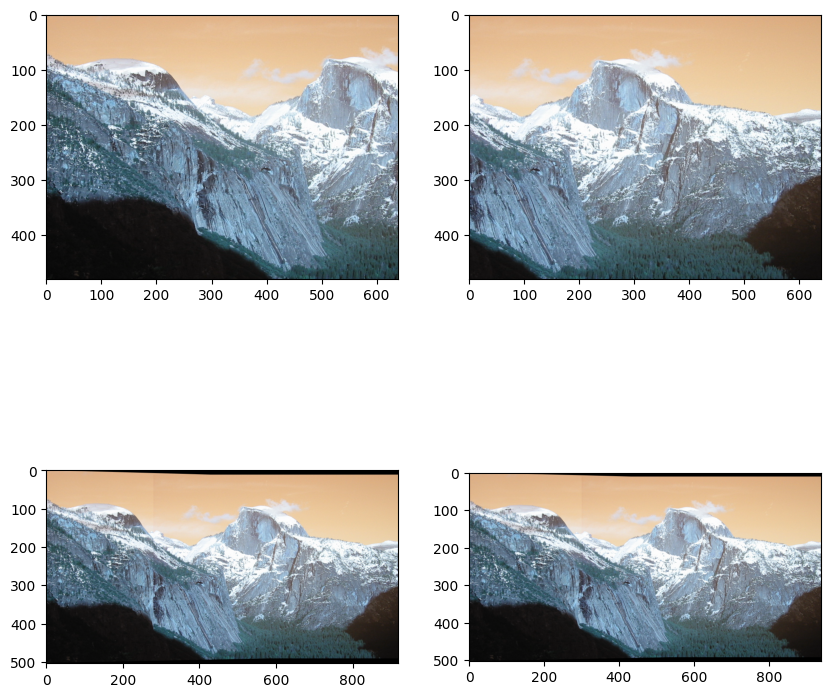

In [32]:
img1 = img_list[10]
img2 = img_list[11]
H = BA.bundleHomo[1][0]
H_1 = fe.homographies[10][11]
G_1 = [1,1,1]
G_2 = [1,1,1]
s = stitch_images(img1,img2,H,G_1,G_2)
s_1 = stitch_images(img1,img2,H_1,G_1,G_2)

ax, fig = plt.subplots(2,2,figsize=(10,10))
fig[0,0].imshow(img1)
fig[0,1].imshow(img2)
fig[1,0].imshow(s)
fig[1,1].imshow(s_1)